In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn import datasets

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('housing.csv')

In [4]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


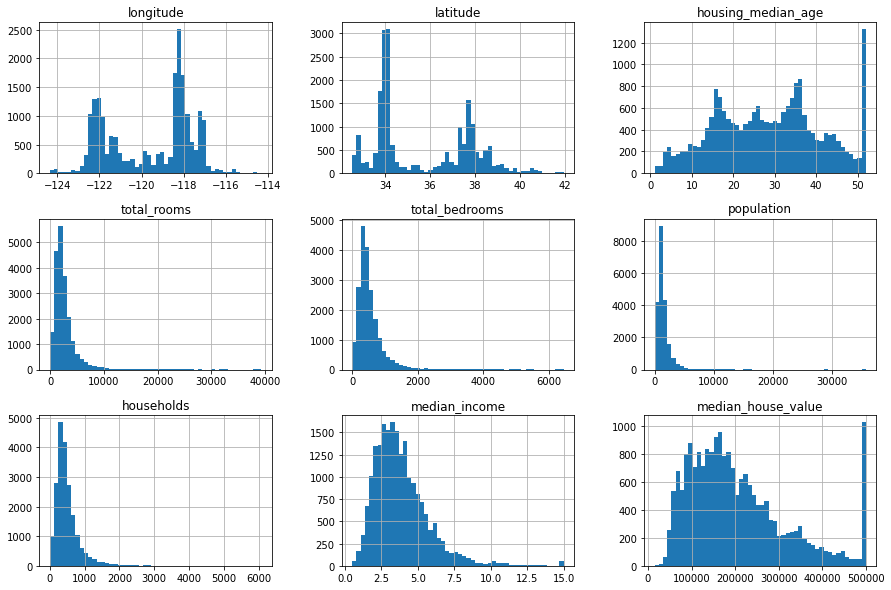

In [5]:
df.hist(figsize=(15,10),bins=50)
plt.show()

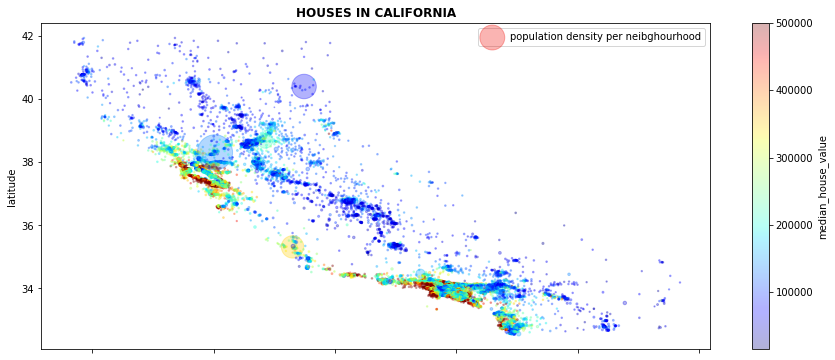

In [6]:
df.plot(figsize=(15,6),kind='scatter',x='longitude',y='latitude',alpha=0.3,
        s=df['population']/df['households'],c='median_house_value',cmap='jet',label='population density per neibghourhood')
plt.title('HOUSES IN CALIFORNIA',fontweight='bold')
plt.legend()
plt.show()

In [7]:
df.value_counts('median_house_value',sort=True)

median_house_value
500001.0    965
137500.0    122
162500.0    117
112500.0    103
187500.0     93
           ... 
383000.0      1
383100.0      1
383200.0      1
36600.0       1
56300.0       1
Length: 3842, dtype: int64

In [8]:
df.value_counts('housing_median_age',sort=True).head(5)

housing_median_age
52.0    1273
36.0     862
35.0     824
16.0     771
17.0     698
dtype: int64

In [9]:
df=df[df['median_house_value']!=500001]
#df=df[df['housing_median_age']!=52]

In [10]:
#df=df.sample(n=1000)

In [11]:
df['avg_rooms']=df['total_rooms']/df['households']
df['avg_bedrooms']=df['total_bedrooms']/df['total_rooms']
df['population_density']=df['population']/df['households']

In [12]:
df.corr()['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.642611
total_rooms           0.143139
avg_rooms             0.109673
households            0.094894
total_bedrooms        0.074672
housing_median_age    0.067948
population            0.011964
population_density   -0.021465
longitude            -0.046658
latitude             -0.148289
avg_bedrooms         -0.215950
Name: median_house_value, dtype: float64

In [13]:
from sklearn.impute import SimpleImputer
imputer_mean=SimpleImputer(strategy='mean')
imputer_mode=SimpleImputer(strategy='most_frequent')

In [14]:
nan_columns=df.columns[df.isna().any()]
for nan_column in nan_columns:
    x=df[nan_column].isna().sum()
    y=round(df[nan_column].isna().sum()/len(df[nan_column]),2)
    if df[nan_column].dtypes=='object' and y<0.5:
        df[nan_column]=imputer_mode.fit_transform(df[[nan_column]])
    elif df[nan_column].dtypes in ['int','float'] and y<0.5:
        df[nan_column]=imputer_mean.fit_transform(df[[nan_column]])
    elif y>0.5:
        df.drop(nan_column,axis=1,inplace=True)

In [15]:
df[df.isna().any(axis=1)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,avg_rooms,avg_bedrooms,population_density


In [16]:
object_columns=df.select_dtypes('object')
for object_column in object_columns:
    dummies=pd.get_dummies(df[object_column],prefix=object_column,dummy_na=False)
    df=df.drop(object_column,axis=1)
    df=pd.concat([df,dummies],axis=1)

In [17]:
df.columns=df.columns.str.replace('>','').str.replace('<','')

In [18]:
X=df.drop('median_house_value',axis=1)
Y=df['median_house_value']

In [19]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest=train_test_split(X,Y,test_size=0.2,random_state=12)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

model_lr=LogisticRegression()
model_svr=SVR()
model_xgbr=XGBRegressor()
model_dtr=DecisionTreeRegressor()
model_rfr=RandomForestRegressor()

models=[model_lr,model_svr,model_xgbr,model_dtr,model_rfr]

In [21]:
from sklearn import metrics

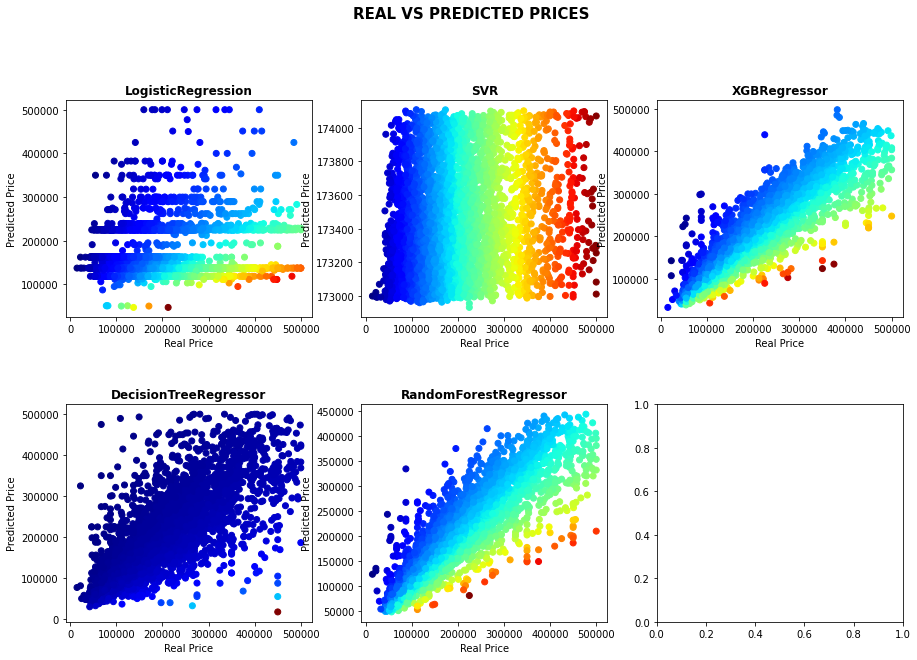

In [22]:
import math

dictionary={}
figure,axes=plt.subplots(2,3,figsize=(15,10))

for model,ax in zip(models,axes.ravel()):
    model.fit(xtrain,ytrain)
    xtest_prediction=model.predict(xtest)
    
    model_str=str(model).split('(')[0]
    mae=metrics.mean_absolute_error(xtest_prediction,ytest)
    rmse=math.sqrt(metrics.mean_squared_error(xtest_prediction,ytest))
    r2=metrics.r2_score(xtest_prediction,ytest)
    
    dictionary[model_str]={'MAE':mae,'RMSE':rmse,'R2':r2}
    
    ax.scatter(ytest,xtest_prediction,c=ytest/xtest_prediction,cmap='jet')
    ax.set_title(model_str,fontweight='bold')
    ax.set_xlabel('Real Price')
    ax.set_ylabel('Predicted Price')

plt.suptitle('REAL VS PREDICTED PRICES',size=15,fontweight='bold')
plt.subplots_adjust(hspace=0.4,top=0.85)
plt.show()

In [23]:
dictionary

{'LogisticRegression': {'MAE': 80182.71944091487,
  'RMSE': 105482.00205995869,
  'R2': -2.7444662180047903},
 'SVR': {'MAE': 75764.87280023271,
  'RMSE': 98867.34538065133,
  'R2': -102434.63630621094},
 'XGBRegressor': {'MAE': 28698.02282500794,
  'RMSE': 42458.43750549294,
  'R2': 0.7710102013206943},
 'DecisionTreeRegressor': {'MAE': 43243.990088945364,
  'RMSE': 65905.08078471952,
  'R2': 0.5541372032673482},
 'RandomForestRegressor': {'MAE': 30472.51024396442,
  'RMSE': 45598.84689025955,
  'R2': 0.710234277973016}}

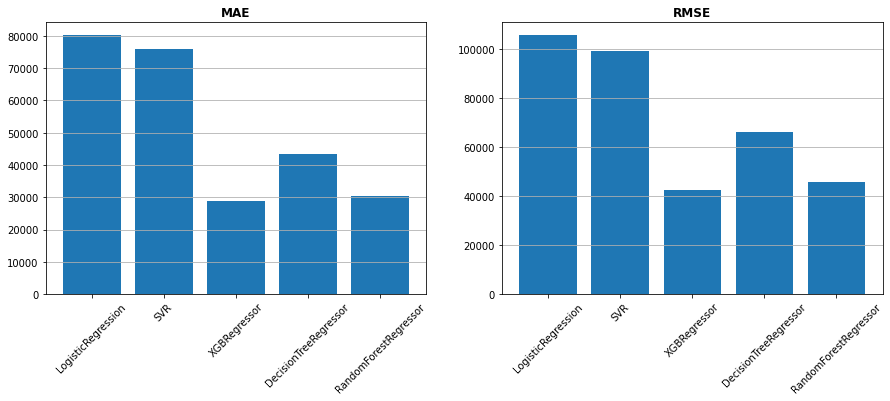

In [24]:
figure,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.bar([key for key,value in dictionary.items()],[value['MAE'] for key,value in dictionary.items()])
ax1.set_title('MAE',fontweight='bold')
ax1.grid(axis='y')
ax1.set_xticklabels([key for key,value in dictionary.items()],rotation=45)

ax2.bar([key for key,value in dictionary.items()],[value['RMSE'] for key,value in dictionary.items()])
ax2.set_title('RMSE',fontweight='bold')
ax2.grid(axis='y')
ax2.set_xticklabels([key for key,value in dictionary.items()],rotation=45)

plt.show()

In [ ]:
# the most accurate ML model seems to be XGBRegressor and RandomForestRegressor
# MAE for XGBR is 28698 and for RFR 30472, which is a good result